<a href="https://colab.research.google.com/github/danilotpnta/FACT-project/blob/master/get_image_caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Example at: https://colab.research.google.com/drive/1Ho81RBV8jysZ7e0FhsSCk_v938QeDuy3?usp=sharing

In [1]:
!git clone --single-branch --branch feature/add_transformers https://github.com/OFA-Sys/OFA.git

Cloning into 'OFA'...
remote: Enumerating objects: 5745, done.
remote: Counting objects: 100% (916/916), done.
remote: Compressing objects: 100% (254/254), done.
remote: Total 5745 (delta 695), reused 662 (delta 662), pack-reused 4829
Receiving objects: 100% (5745/5745), 97.78 MiB | 33.39 MiB/s, done.
Resolving deltas: 100% (2243/2243), done.


In [2]:
!pip install OFA/transformers/

Processing ./OFA/transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 5.6 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.18.0.dev0-py3-none-any.whl size=3916748 sha256=1df4910e08653cc39abc3855394ae0eb41326bd1414ad2159ba635ae43526595
  Stored in directory: /tmp/pip-ephem-wheel-cache-__gvsfe0/wheels/0b/bc/ea/00b6b8998c20c4fe55affe6062a2cddda80308ef9bd5d5877c
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [3]:
!git lfs install
!git clone https://huggingface.co/OFA-Sys/OFA-large

Git LFS initialized.
Cloning into 'OFA-large'...
remote: Enumerating objects: 55, done.
remote: Total 55 (delta 0), reused 0 (delta 0), pack-reused 55
Unpacking objects: 100% (55/55), 541.20 KiB | 4.92 MiB/s, done.


In [4]:
from PIL import Image
import torch
import os
from torchvision import transforms
from transformers import OFATokenizer, OFAModel, OFAConfig
# from generate import sequence_generator
from transformers.models.ofa.generate import sequence_generator
# from OFA.fairseq.fairseq import sequence_generator


In [6]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480
patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# ckpt_dir = '/home/scur1045/FACT-project/OFA/OFA-HF-large-model'
ckpt_dir = 'OFA-large'
tokenizer = OFATokenizer.from_pretrained(ckpt_dir)
# tokenizer = OFATokenizer(vocab_file=f'{ckpt_dir}/vocab.json', merges_file=f'{ckpt_dir}/merges.txt')

OFA-large
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [11]:
txt = " what does the image describe?"
inputs = tokenizer([txt], return_tensors="pt").input_ids
# path_to_image = '/home/scur1045/FACT-project/HVV_EXPGEN_DATASET/Train_Val_Images/covid_memes_2076.png'
# path_to_image = '/home/scur1045/FACT-project/HVV_EXPGEN_DATASET/Train_Val_Images/memes_1452.png'
# path_to_image = 'img_test.png'
path_to_image = 'memes_1452.png'
img = Image.open(path_to_image)
patch_img = patch_resize_transform(img).unsqueeze(0)

In [12]:
model = OFAModel.from_pretrained(ckpt_dir, use_cache=True)
generator = sequence_generator.SequenceGenerator(
                    tokenizer=tokenizer,
                    beam_size=5,
                    max_len_b=16,
                    min_len=0,
                    no_repeat_ngram_size=3,
                )

In [13]:
data = {}
data["net_input"] = {"input_ids": inputs, 'patch_images': patch_img, 'patch_masks':torch.tensor([True])}
gen_output = generator.generate([model], data)
gen = [gen_output[i][0]["tokens"] for i in range(len(gen_output))]

# using the generator of huggingface version
# model = OFAModel.from_pretrained(ckpt_dir, use_cache=False)
# gen = model.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)


## Examples

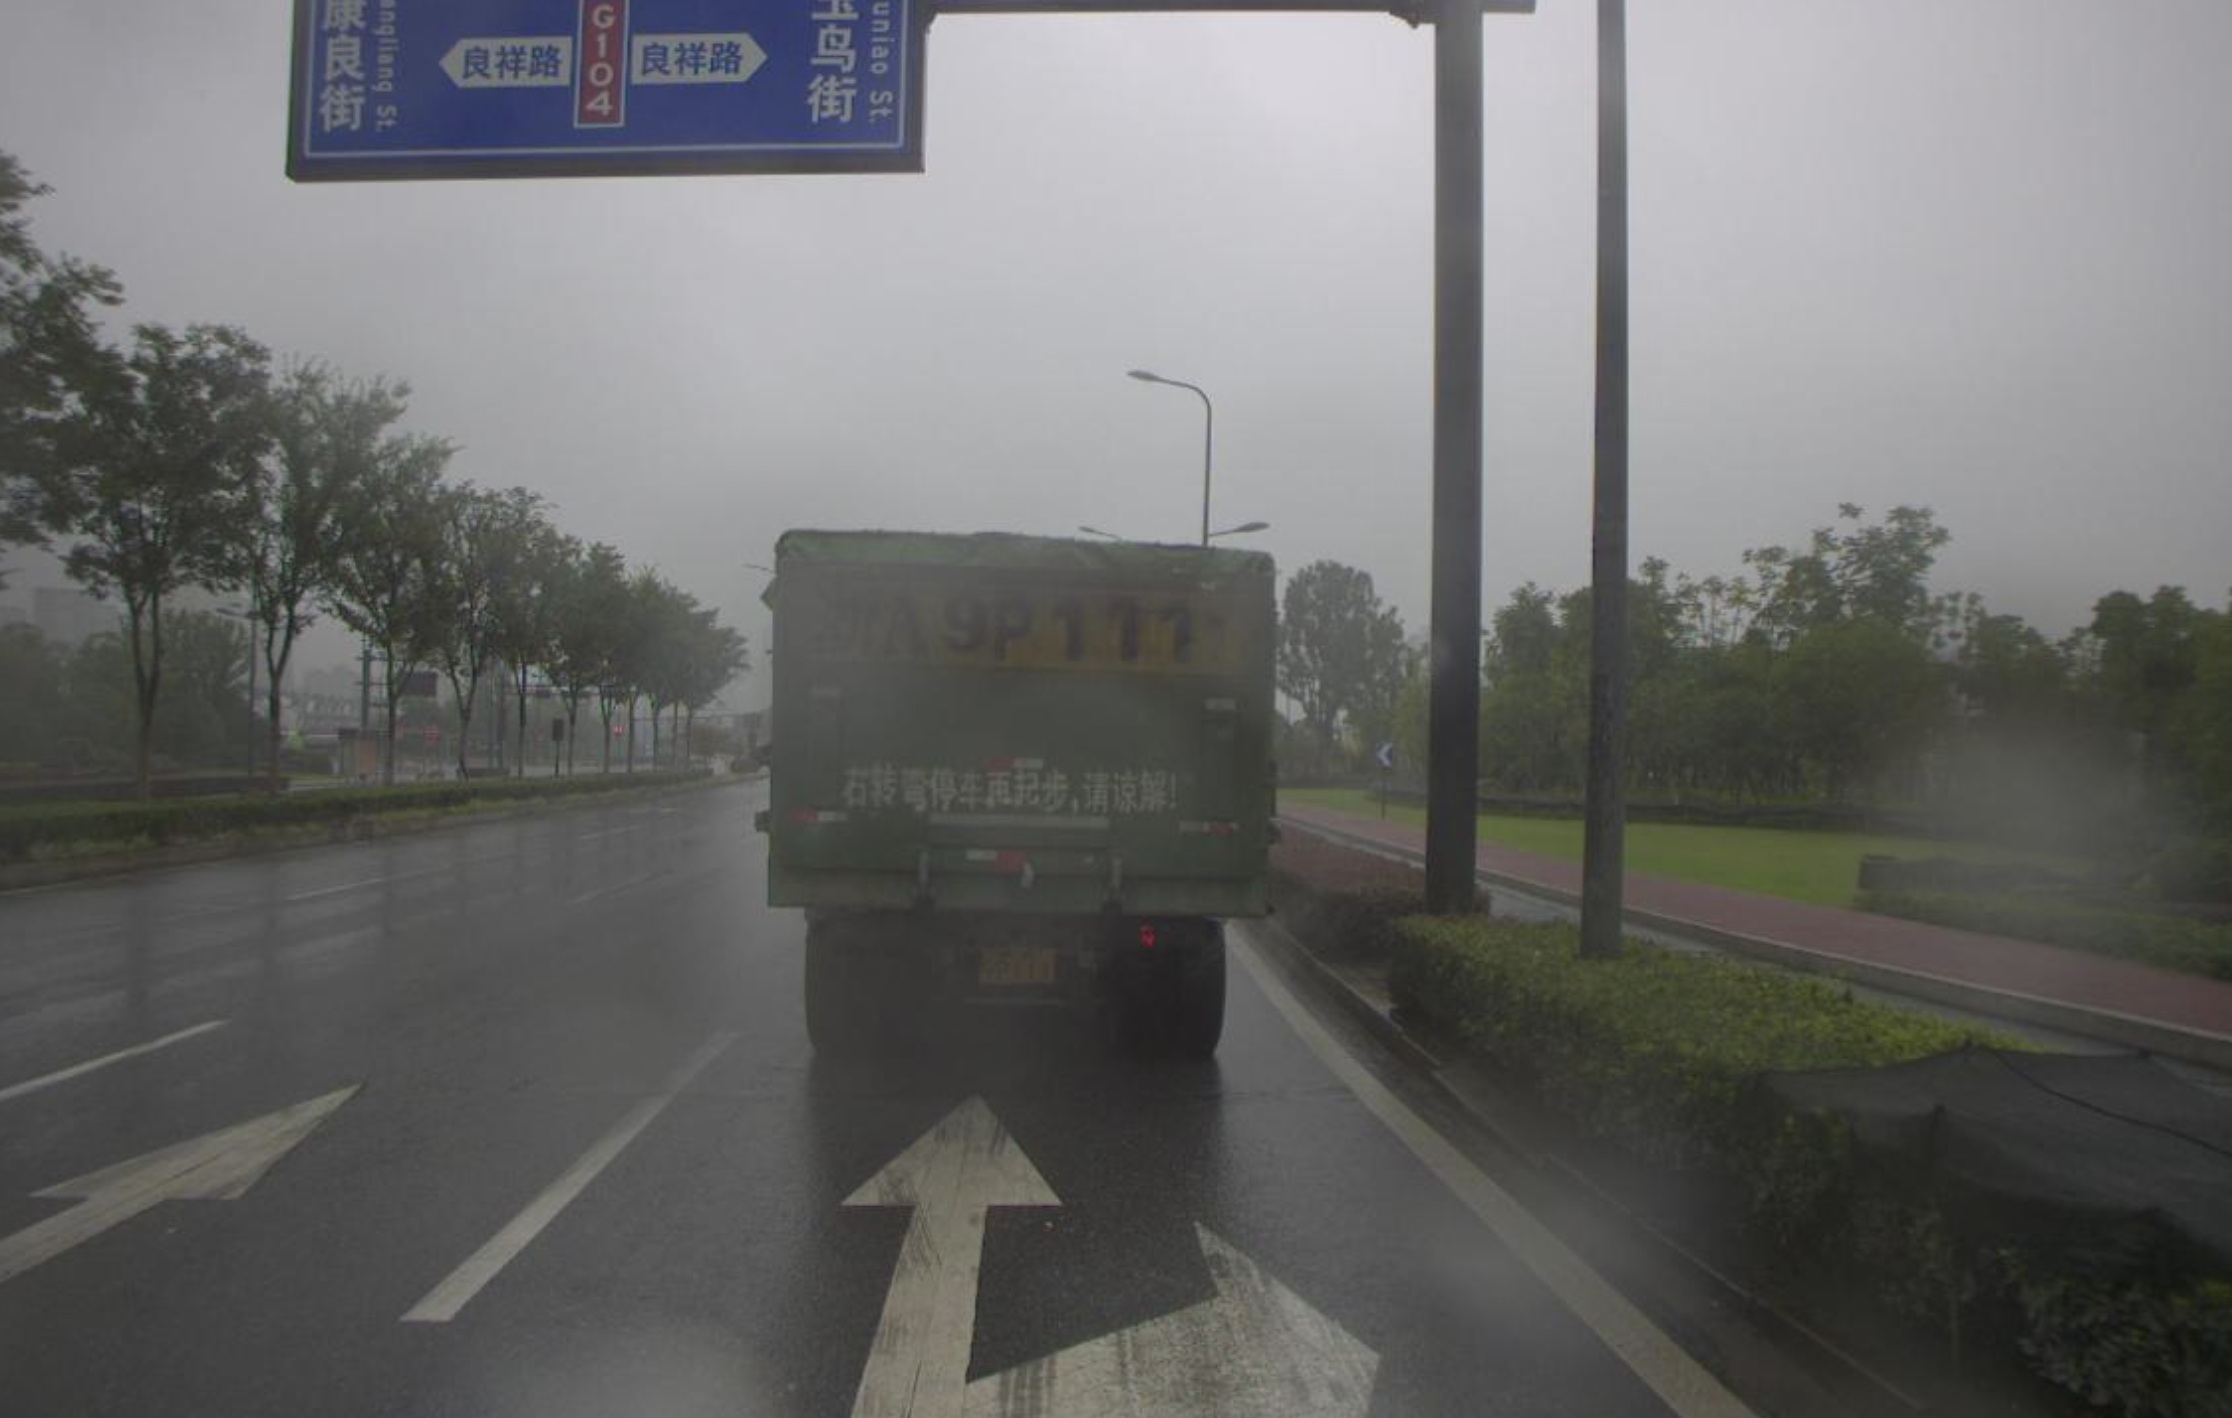

a truck drives on a road in wuhan, hubei province.


In [9]:
display(img)
print(tokenizer.batch_decode(gen, skip_special_tokens=True)[0].strip())

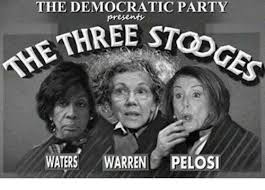

poster of the movie the three stooges


In [14]:
display(img)
print(tokenizer.batch_decode(gen, skip_special_tokens=True)[0].strip())

The caption at `sample_train50.csv` is:

*   *the three stooges poster for the documentary party*

